Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

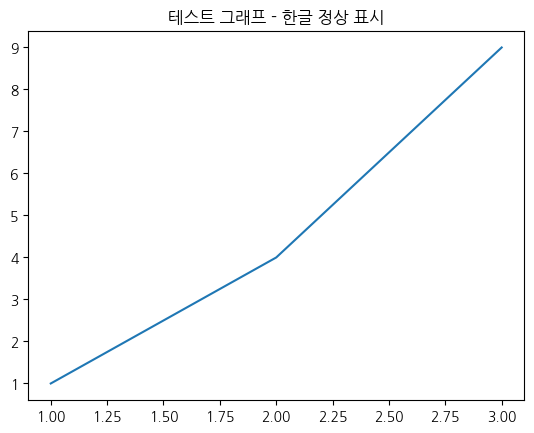

In [1]:
# @title
!apt-get -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib
import matplotlib.font_manager as fm
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Nanum" in font:
        print(font)


font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()  # 실제 패밀리명 얻기
mpl.rcParams["font.family"] = font_name
mpl.rcParams["axes.unicode_minus"] = False

print("사용 폰트:", font_name)

plt.plot([1,2,3],[1,4,9])
plt.title("테스트 그래프 - 한글 정상 표시")
plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import seaborn as sns

df = pd.read_csv('ai_job_market.csv')

print(df.columns)

Index(['job_id', 'company_name', 'industry', 'job_title', 'skills_required',
       'experience_level', 'employment_type', 'location', 'salary_range_usd',
       'posted_date', 'company_size', 'tools_preferred'],
      dtype='object')


In [3]:
# 1. skills_required 안전하게 처리
def process_skills(x):
    if isinstance(x, list):
        return [s.strip() for s in x]
    elif isinstance(x, str):
        return [s.strip() for s in x.split(',')]
    else:
        return []

df['skills_required'] = df['skills_required'].apply(process_skills)

# 2. 기술별로 행 분리
df_exploded = df.explode('skills_required').reset_index(drop=True)

# 3. salary_min 처리
df_exploded['salary_min'] = (
    df_exploded['salary_range_usd']
    .astype(str)  # 혹시 숫자형 혼합 방지
    .str.split('-')
    .str[0]
    .str.replace('[\$,]', '', regex=True)  # $나 , 제거
    .astype(float)
)

# 4. posted_date 처리
df_exploded['posted_date'] = pd.to_datetime(df_exploded['posted_date'], errors='coerce')
df_exploded['year'] = df_exploded['posted_date'].dt.year
df_exploded['half_year'] = df_exploded['posted_date'].dt.month.apply(lambda m: 'H1' if m <= 6 else 'H2')

# 확인
print(df_exploded[['skills_required', 'salary_min', 'posted_date', 'year', 'half_year']].head(10))


          skills_required  salary_min posted_date  year half_year
0                   NumPy     92860.0  2025-08-20  2025        H2
1  Reinforcement Learning     92860.0  2025-08-20  2025        H2
2                 PyTorch     92860.0  2025-08-20  2025        H2
3            Scikit-learn     92860.0  2025-08-20  2025        H2
4                     GCP     92860.0  2025-08-20  2025        H2
5                 FastAPI     92860.0  2025-08-20  2025        H2
6            Scikit-learn     78523.0  2024-03-22  2024        H1
7                    CUDA     78523.0  2024-03-22  2024        H1
8                     SQL     78523.0  2024-03-22  2024        H1
9                  Pandas     78523.0  2024-03-22  2024        H1


<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2929066757.py:21: SyntaxWarning: invalid escape sequence '\$'
  .str.replace('[\$,]', '', regex=True)  # $나 , 제거


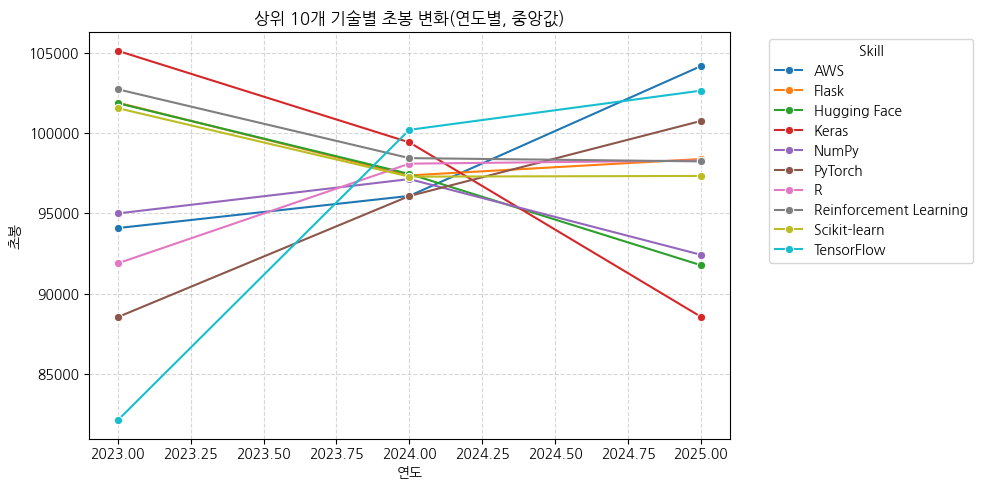

In [4]:
# posted_date에서 연도 추출
df_exploded['year'] = pd.to_datetime(df_exploded['posted_date']).dt.year

# 상위 10개 기술 선택
top_skills = df_exploded.groupby('skills_required')['salary_min'] \
            .median().sort_values(ascending=False).head(10).index

df_top = df_exploded[df_exploded['skills_required'].isin(top_skills)]

# 기술별 연도별 중앙값 집계
salary_trend = df_top.groupby(['year','skills_required'])['salary_min'].median().reset_index()

# Line plot
plt.figure(figsize=(10,5))
sns.lineplot(data=salary_trend, x='year', y='salary_min', hue='skills_required', marker='o')
plt.xlabel('연도')
plt.ylabel('초봉')
plt.title('상위 10개 기술별 초봉 변화(연도별, 중앙값)')
plt.legend(title='Skill', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


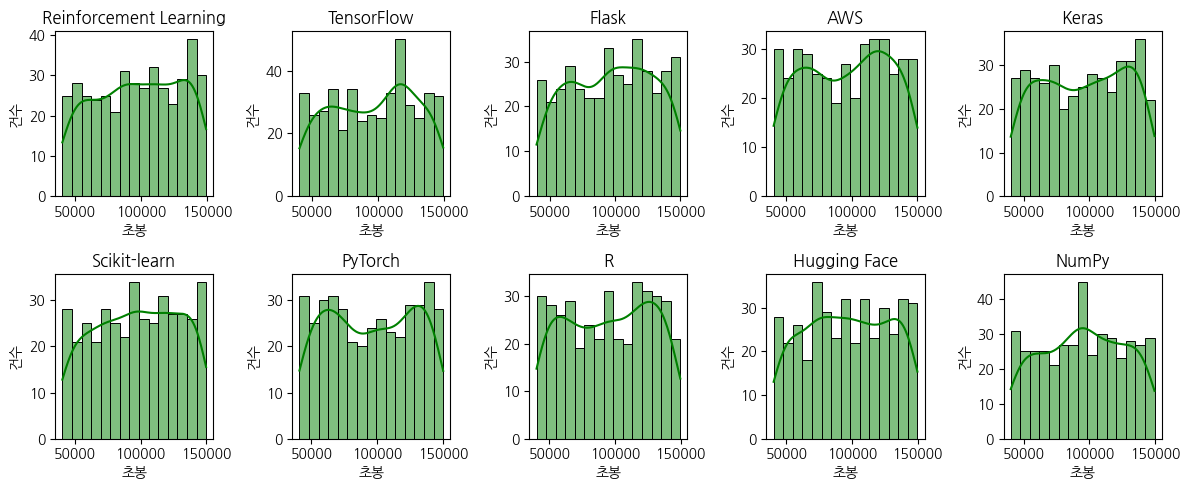

In [5]:
# 상위 10개 기술 선택 (중앙값 기준)
top_skills = df_exploded.groupby('skills_required')['salary_min'] \
            .median().sort_values(ascending=False).head(10).index

# 서브플롯 2행 5열 생성
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,5))
axes = axes.flatten()

for i, skill in enumerate(top_skills):
    ax = axes[i]
    sns.histplot(df_exploded[df_exploded['skills_required'] == skill]['salary_min'],
                 bins=15, kde=True, color='green', ax=ax)
    ax.set_title(skill)
    ax.set_xlabel('초봉')
    ax.set_ylabel('건수')

plt.tight_layout()
plt.show()


In [6]:
# 원본 데이터 기준 직업군 등장 횟수
job_counts_original = df['job_title'].value_counts()

# DataFrame 형태로 변환해서 보기 좋게 만들기
job_counts_df = job_counts_original.reset_index()
job_counts_df.columns = ['job_title', 'count']

# 전체 직업군 + 등장 횟수 확인
print("전체 직업군 수:", len(job_counts_df))
print(job_counts_df.to_string())


전체 직업군 수: 8
                  job_title  count
0              Data Analyst    271
1              NLP Engineer    265
2        AI Product Manager    258
3          Quant Researcher    251
4               ML Engineer    250
5            Data Scientist    238
6             AI Researcher    237
7  Computer Vision Engineer    230


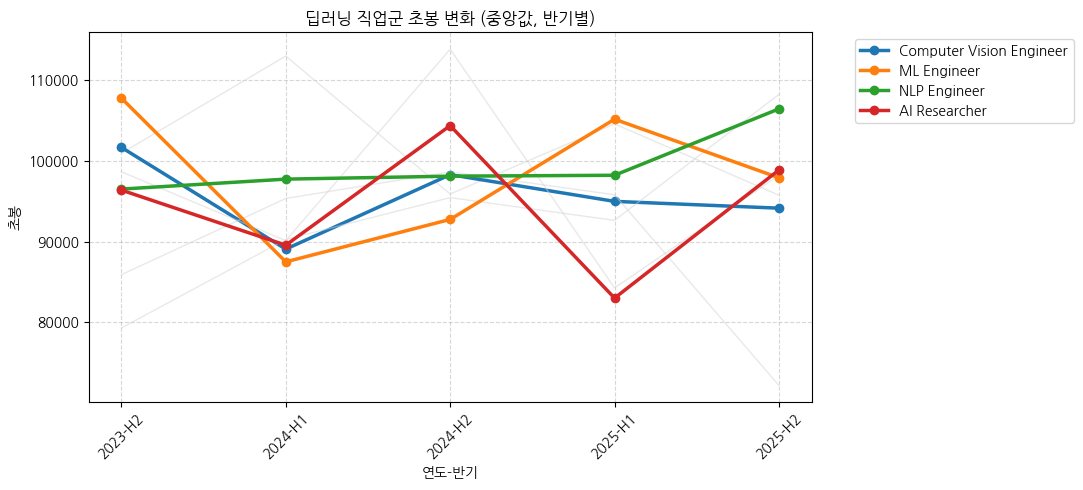

In [7]:
df_exploded['year_half'] = df_exploded['year'].astype(str) + '-' + df_exploded['half_year']

# 상위 4개 딥러닝 직업군 정의
top_jobs = ['AI Researcher', 'Computer Vision Engineer', 'NLP Engineer', 'ML Engineer']

plt.figure(figsize=(11,5))

# 직업군별 반기별 중앙값 초봉 라인
for job in df_exploded['job_title'].unique():
    trend = df_exploded[df_exploded['job_title']==job].groupby('year_half')['salary_min'].median()
    if job in top_jobs:
        plt.plot(trend.index, trend.values, marker='o', linewidth=2.5, label=job)
    else:
        plt.plot(trend.index, trend.values, color='lightgray', alpha=0.5, linewidth=1)

plt.title('딥러닝 직업군 초봉 변화 (중앙값, 반기별)')
plt.xlabel('연도-반기')
plt.ylabel('초봉')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
